In [71]:
import networkx as nx
import numpy as np
from simulation import Simulation
import matplotlib.pyplot as plt
import random

In [72]:
def gen_exp_graph(N, gamma):
    """
    Returns a networx graph according to a power law degree distribution
    """
    sum_is_odd = True

    sequence = []
    
    while sum_is_odd:
        sequence = np.array(nx.utils.powerlaw_sequence(N, gamma), dtype=int)
        sum_is_odd = np.sum(sequence) % 2 == 1


    return nx.configuration_model(sequence)



In [73]:
graphs = []
n_graphs = 100
N = 100
for i in range(n_graphs):
    #gamma = 2.0 + 0.5 / n_graphs * i
    gamma = 2.1
    
    G = gen_exp_graph(N, gamma)
    graphs.append(G)

In [74]:
def compute_B(G, D_I, beta, mu, n_walkers):
    largest_cc = max(nx.connected_components(G), key=len)
    F = G.subgraph(largest_cc).copy()

    N_tilde = F.number_of_nodes()
    B = np.zeros((N_tilde,N_tilde))
    A = nx.to_numpy_array(F)
    degs = np.array([d for v, d in F.degree()])

    avg_deg = np.average(degs)
    for i in range(N_tilde):
        for j in range(N_tilde):
            eq = int(i == j)
            B[i,j] += eq * ((beta * n_walkers) / (avg_deg * G.number_of_nodes()) * degs[i] - mu - D_I)
            B[i,j] += (1- eq) * D_I * A[j,i] / degs[j]
    return B

In [75]:
D_S = 0.9 # Rate at which an infected walker jumps to a new node
D_I = 0.1 # Rate at which a susceptible walker jumps to a new node
beta = 1 / 1000 # Rate at which an infected walker recovers
mu = 1 / 10  # Rate at which a susceptible walker is infected
n_walkers = 5000

print("parameter values:" + " D_S = " + str(D_S) + " D_I = " + str(D_I) + " beta = " + str(beta) + " mu = " + str(mu) + " n_walkers = " + str(n_walkers))

min_eig = np.inf
max_eig = -np.inf

G_min = None
G_max = None

for i in range(n_graphs):
    B = compute_B(graphs[i], D_I, beta, mu, n_walkers)
    eig, _ = np.linalg.eig(B)
    c = np.max(eig)

    if c < min_eig:
        min_eig = c
        G_min = graphs[i]

    if c > max_eig:
        max_eig = c
        G_max = graphs[i]

print("Min eig: ", min_eig)
print("Max eig: ", max_eig)


parameter values: D_S = 0.9 D_I = 0.1 beta = 0.001 mu = 0.1 n_walkers = 5000
Min eig:  0.0935091654263764
Max eig:  (4.2174406250826255+0j)


In [76]:
sim_min = Simulation(G_min, D_S, D_I, beta, mu)\
    .init_walkers_uniform(n_walkers=n_walkers)\
    .infect_walkers(percentage=0.01)\
    .run(duration=10, storage_interval=0.003, storage_mode='log')

sim_max = Simulation(G_max, D_S, D_I, beta, mu)\
    .init_walkers_uniform(n_walkers=n_walkers)\
    .infect_walkers(percentage=0.01)\
    .run(duration=10, storage_interval=0.003, storage_mode='log')

/home/arehmann/projects/networks/ex11/simulation.py:101: RuntimeWarning: divide by zero encountered in log
  if storage_mode == 'log' and np.log(self.t) - np.log(checkpoint) > storage_interval:
/home/arehmann/projects/networks/ex11/simulation.py:101: RuntimeWarning: invalid value encountered in double_scalars
  if storage_mode == 'log' and np.log(self.t) - np.log(checkpoint) > storage_interval:


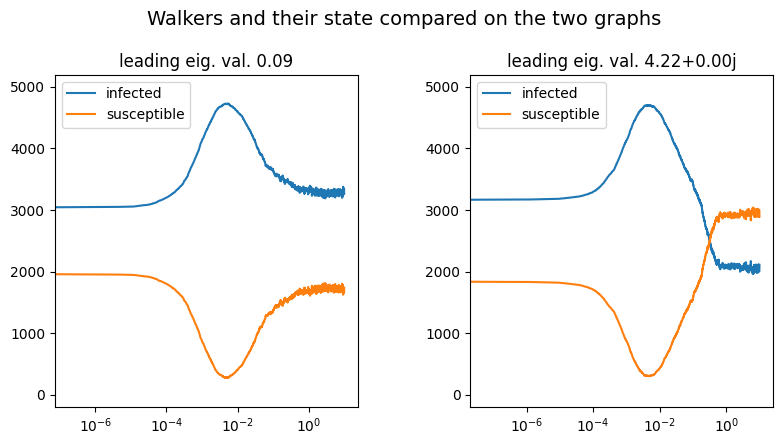

In [95]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
fig.tight_layout(pad=5.0)

fig.suptitle("Walkers and their state compared on the two graphs", fontsize=14)

ax1.plot(sim_min.timeline, np.sum(sim_min.infected_log, axis=1), label='infected')
ax2.plot(sim_max.timeline, np.sum(sim_max.infected_log, axis=1), label='infected')

ax1.plot(sim_min.timeline, np.sum(sim_min.node_log - sim_min.infected_log, axis=1), label='susceptible')
ax2.plot(sim_max.timeline, np.sum(sim_max.node_log - sim_max.infected_log, axis=1), label='susceptible')


ax1.set_title('leading eig. val. ' + "{:.2f}".format(min_eig))
ax2.set_title('leading eig. val. ' + "{:.2f}".format(max_eig))

ax1.legend()
ax2.legend()
ax1.set_xscale('log')
ax2.set_xscale('log')


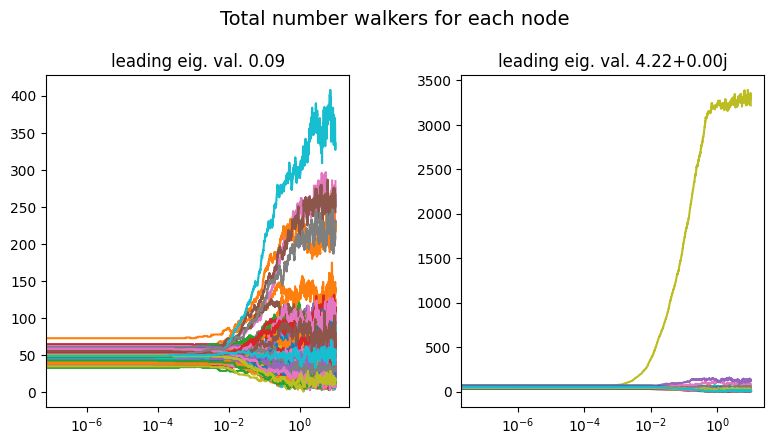

In [96]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
fig.tight_layout(pad=5.0)

fig.suptitle("Total number walkers for each node", fontsize=14)

for i in range(sim_max.G.number_of_nodes()):
    ax1.plot(sim_min.timeline, sim_min.node_log[:,i], label='walkers')
    ax2.plot(sim_max.timeline, sim_max.node_log[:,i], label='walkers')

ax1.set_title('leading eig. val. ' + "{:.2f}".format(min_eig))
ax2.set_title('leading eig. val. ' + "{:.2f}".format(max_eig))

ax1.set_xscale('log')
ax2.set_xscale('log')


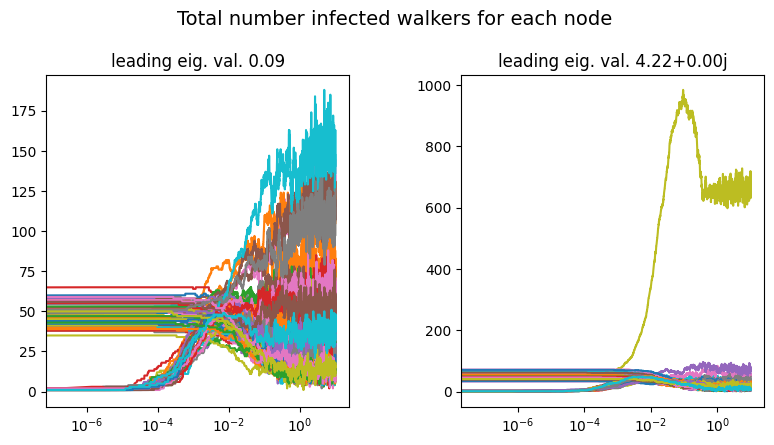

In [98]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
fig.tight_layout(pad=5.0)

fig.suptitle("Total number infected walkers for each node", fontsize=14)

for i in range(sim_max.G.number_of_nodes()):
    ax1.plot(sim_min.timeline, sim_min.infected_log[:,i], label='infected')
    ax2.plot(sim_max.timeline, sim_max.infected_log[:,i], label='infected')

ax1.set_title('leading eig. val. ' + "{:.2f}".format(min_eig))
ax2.set_title('leading eig. val. ' + "{:.2f}".format(max_eig))

ax1.set_xscale('log')
ax2.set_xscale('log')


Interestinlgy the infection appears with around the same speed in the beginning of the simulation when looking at absolute values. However in the plot showing the the number of infected walkers for each node, a very prominentn outlier is detectable in the graph with the maximal leading eigenvalue. 

In later stages of the graph, the total number of infected walkers is significantly lower for the graph with the maximal leading eigenvalue. When looking at the indivial nodes, the same picture as before is visible, while the distribution of the infected walkers in the min leading eigenvalue graph remains more or less equal, the other graph still displays a massive grouping of infected walkers on a single node.

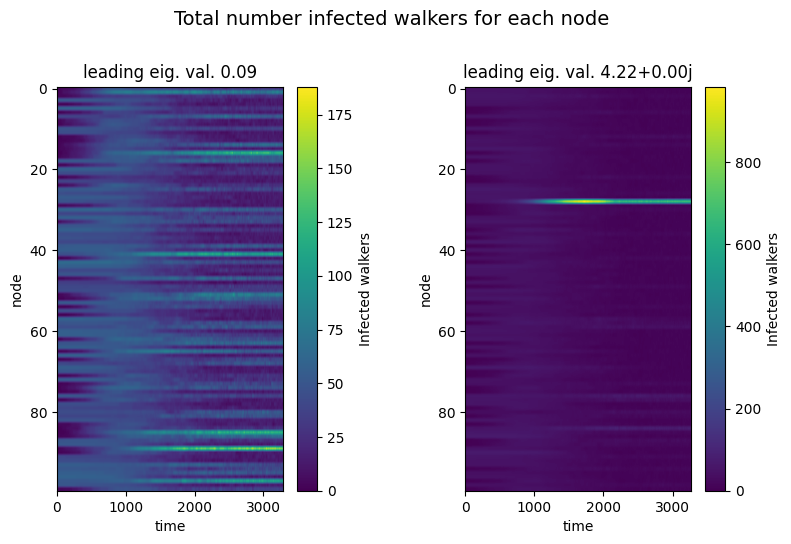

In [99]:
fig, (axs) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
fig.tight_layout(pad=6.0)

fig.suptitle("Total number infected walkers for each node", fontsize=14)

im1 = axs[0].imshow(sim_min.infected_log.T, aspect='auto')
im2 = axs[1].imshow(sim_max.infected_log.T, aspect='auto')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='node')

axs[0].set_title('leading eig. val. ' + "{:.2f}".format(min_eig))
axs[1].set_title('leading eig. val. ' + "{:.2f}".format(max_eig))

fig.colorbar(im1, ax=axs[0], label='Infected walkers')
fig.colorbar(im2, ax=axs[1], label='Infected walkers')

The heatwave shows the same picture in a different way: A bit more appraent are the clusterings of infected walkers which is also visible in the graph with the minimal leading eigenvalue.

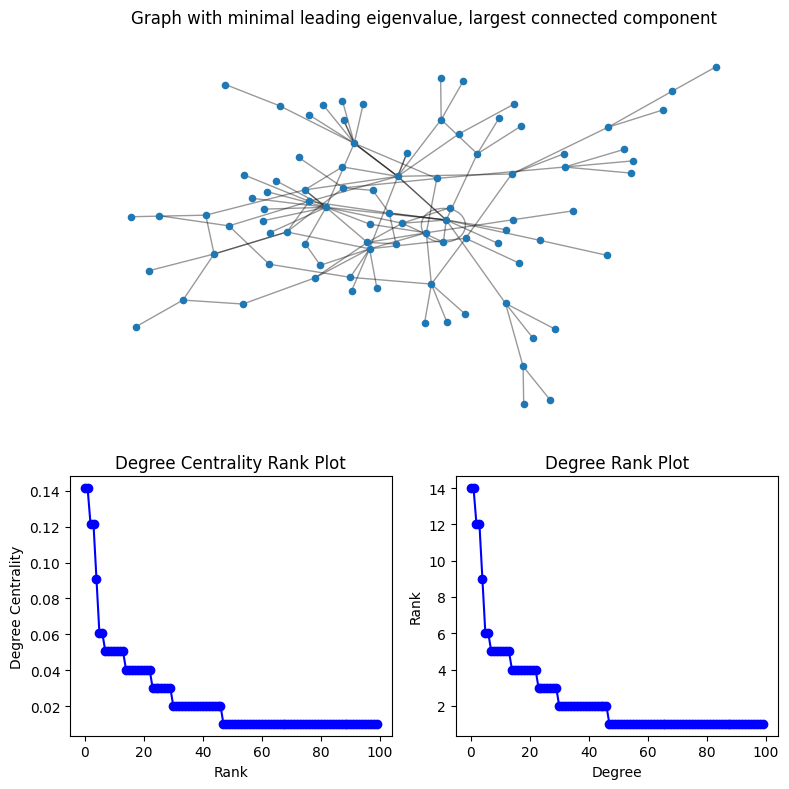

In [80]:
deg_cen_seq_min = sorted(nx.degree_centrality(G_min).values(), reverse=True)
deg_seq_min = sorted([val for (node, val) in G_min.degree()], reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G_min.subgraph(sorted(nx.connected_components(G_min), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Graph with minimal leading eigenvalue, largest connected component")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(deg_cen_seq_min, "b-", marker="o")
ax1.set_title("Degree Centrality Rank Plot")
ax1.set_ylabel("Degree Centrality")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.plot(deg_seq_min, "b-", marker="o")
ax2.set_title("Degree Rank Plot")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Rank")

fig.tight_layout()
plt.show()

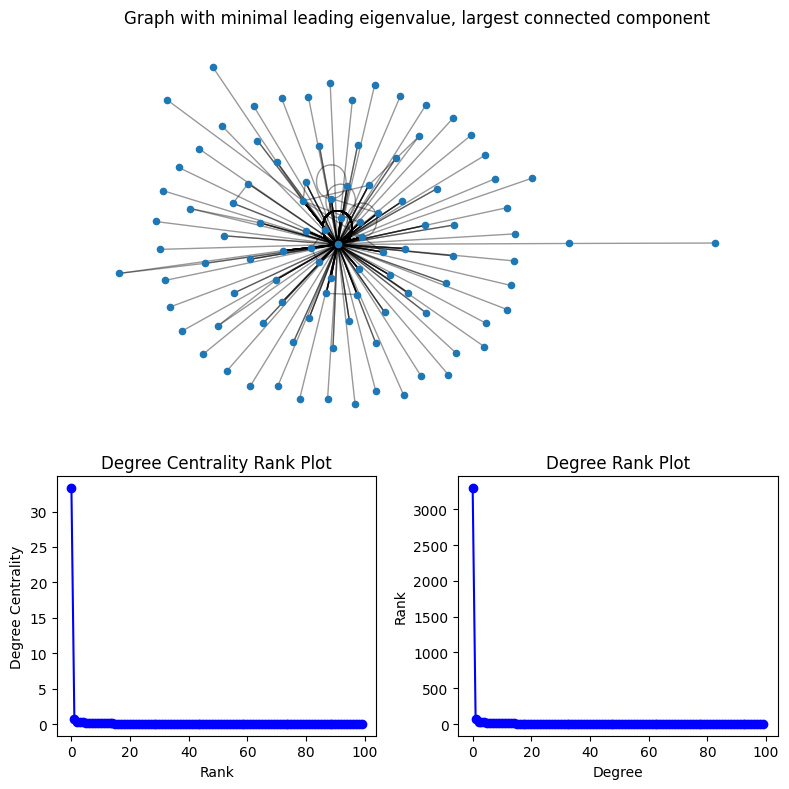

In [81]:
deg_cen_seq_max = sorted(nx.degree_centrality(G_max).values(), reverse=True)
deg_seq_max = sorted([val for (node, val) in G_max.degree()], reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G_max.subgraph(sorted(nx.connected_components(G_max), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Graph with minimal leading eigenvalue, largest connected component")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(deg_cen_seq_max, "b-", marker="o")
ax1.set_title("Degree Centrality Rank Plot")
ax1.set_ylabel("Degree Centrality")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.plot(deg_seq_max, "b-", marker="o")
ax2.set_title("Degree Rank Plot")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Rank")

fig.tight_layout()
plt.show()

In order to make sense of the infected walker distribution we take a look at the degree analysis of both graphs. Already in the simple visual plot of the largest components, its clear how the graph with the minimal leading eigenvalue has much more nodes wich are connected to many other nodes. The other graph shows a strong concentration on a single central node (hub).

The same thing is also visible on the rank plots of the degree centrality and degrees. The graph with the minimal leading eigenvalu has a distribution which much more resembles a power law distibution. The other however, by chance is identical to star graph.

However this does still not completely explain the behaviour.

Initially both graphs behave similar: This is because the walkers and also the percentage of infected walkers are uniformly distributed among the nodes. Initially the likelihood of a suspectible walker to get infected is thus mostly governed by the number of already infected walkers on the same node. This likelihood is equal as the paremeters chosen for both simulations.

Now at later stages of the simulation, we can see how for the graph with the max leading eigenv. the number of infected but also the total number of walkers are concentrated largely on the same node, the central hub. This also makes sense, the likelihood of an infection clearly is very large on the central hub, as a lot of walkers and thus also a lot of infected walkers pass the node, since almost every path in the graph goes thrue the hub. 

But why is the total number of infected walkers lower in the graph with a larger leading eigenvalue? The answer comes from the exponential distribution which is used to sample the likelihoods of the different events. As the number of infected walkers increase on the same the node, the effect this has on the probability becomes smaller and smaller. Meaning if the walkers, or the infected walkers are more evenly distributed among many nodes, the summed likelihood over all nodes is higher as it is the case with the centralized hub.